# Surface classification using 2-forms

In this notebook we show how to integrate $2$- forms in $\mathbb{R}^n$ over a $2$-simplex. A $2$-form $\omega \in\Omega^2(\mathbb{R}^n)$ can be written in coordinates as $\omega = \sum_{0\leq i < j \leq n} f_{i,j} dx_i\wedge dx_j$

### To do: 
- make the code faster, some things do not need to be for loops
- how to choose learning rates and layers etc???

## Wednesday tasks: 

1. modify code so that one can learn mulliple cochains, in the new data format
2. run for longer and make plots of accuracy
3. play around so we get better than 70 percent accuracy

In [103]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import math
import gudhi as gd 
import scipy.special

import k_forms as kf


import torch.optim as optim

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[[0, 1, 5], [1, 2, 6], [1, 5, 6], [2, 3, 7], [2, 6, 7], [3, 4, 8], [3, 7, 8], [4, 8, 9], [5, 6, 10], [6, 7, 11], [6, 10, 11], [7, 8, 12], [7, 11, 12], [8, 9, 13], [8, 12, 13], [9, 13, 14], [10, 11, 15], [11, 12, 16], [11, 15, 16], [12, 13, 17], [12, 16, 17], [13, 14, 18], [13, 17, 18], [14, 18, 19], [15, 16, 20], [16, 17, 21], [16, 20, 21], [17, 18, 22], [17, 21, 22], [18, 19, 23], [18, 22, 23], [19, 23, 24]]


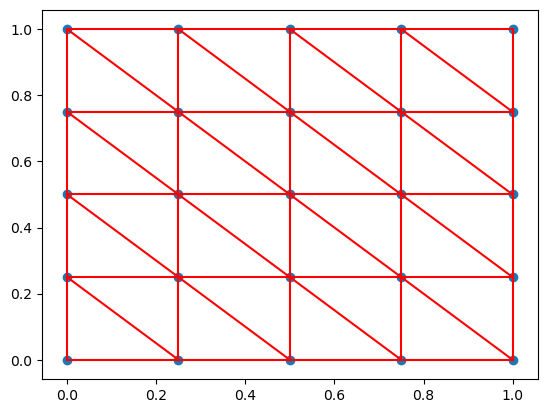

In [104]:
num_pts = 5 
pts , ac = kf.plot_unit_square_grid(num_pts)
simplices = []
for s in ac.get_skeleton(2):
    if len(s[0]) == 3: 
        simplices.append(s[0])

print(simplices)

In [105]:
# generate surface data
num_surf = 10
eps = 3
s0 = kf.generate_surfaces_yz(num_surf, num_pts , eps) ## the surfaces are a bit too regular, change a bit the generation code later
s1 = kf.generate_surfaces_xz(num_surf, num_pts , eps)
#s2 = kf.generate_curved_surfaces(num_surf, num_pts , eps)
surfaces = s0 + s1 

# generate labels
#labels = np.concatenate((np.zeros(num_surf),np.ones(num_surf),2*np.ones(num_surf)))
labels = np.concatenate((np.zeros(num_surf),np.ones(num_surf)))

# perform a one hot encoding of the labels and transform to torch
labels_one_hot = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

## shuffle the data and the labels in the same way
shuffled_indices = torch.randperm(len(surfaces)) 
surfaces_shuffled = [surfaces[i] for i in shuffled_indices]
labels_one_hot_shuffled = labels_one_hot[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

In [106]:
## making dictionaries out of the surfaces
## decide if shuffle or not when doing this 
surfaces_list_shuffled = []
for surf in range(num_surf*2): 
    surface = surfaces_shuffled[surf]
    surface_dict= {}
    surface_dict['simplices'] = simplices
    surface_dict['points'] = surface[3]
    surface_dict['Phi'] = []
    surface_dict['b'] = []


    for i in range(len(surface_dict['simplices'])):
        s = surface_dict['simplices'][i]
        emb_vertices_simplex = surface_dict['points'][s]
        phi_simplex, b_simplex = kf.phi_b(emb_vertices_simplex )
        surface_dict['Phi'].append(phi_simplex)
        surface_dict['b'].append(b_simplex)

    surfaces_list_shuffled.append(surface_dict)


len(surfaces_list_shuffled)

20

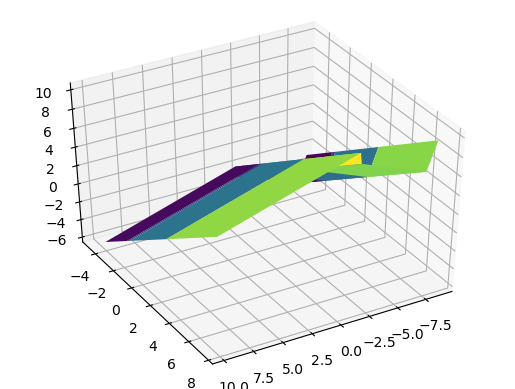

/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


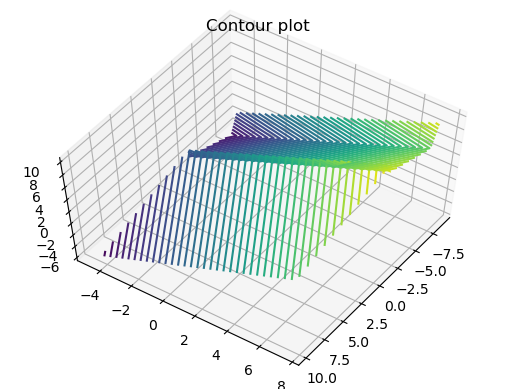

In [107]:
# plot one surface
kf.plot_surface(surfaces[5][0],surfaces[5][1],surfaces[5][2])

# Learn multiple cochains

In [108]:
def integrate_kforms(kform, phi, b, det, subdivision_vert, subdivision_coefs, num_sub, l =1, dim = 3, k = 2):
    """ Integrate l 2-forms over 2-simplex
    Input: 
        kform: l 2-forms
        phi: a matrix containing the embedding of the vertices of the simplex in R^dim
        b: a vector containing the embedding of the basepoint of the simplex in R^dim
        det: the tensor computed by build_determinant_tensor
        l: the number of 2-forms to integrate
        dim: the dimension of the embedding space
        k: the dimension of the form
        subdivision_vert: a list of vertices of the subdivision of the simplex
        subdivision_coefs: a list of coefficients for the contribution of each vertex to the integral
        num_sub: the number of subdivisions of the simplex 
    Output:
        integral: the value of integral of the l 2-forms over the 2-simplex 
    """

    ## TODO: add assert to check inputs 
    ## check  that l and the shape of the k-form are consistent

    ## number of vertices in the subdivision
    num_simplices = int(num_sub**2) ## number of simplices in the subdivision

    N = int(scipy.special.binom(dim,k))

    integrals = torch.zeros(l,1) 

    for i in range(l):
        ## integrate the i-th k-form
        for j in range(len(subdivision_vert)): 
            p = subdivision_vert[j]
            phi_p = phi.T @ p + b
            g_p = torch.tensor([0]).float() 
            for ind in range(i*N, (i+1)*N):
                m = ind - i*N
                #print('m:',m)
                #print('ind: ',ind)
                #print('kform: ',kform(phi_p)[ind])
                
                g_p+= kform(phi_p)[ind] * torch.matmul(torch.matmul(phi[0], det[m]), phi[1].T)
            
            cof = subdivision_coefs[j]


            integrals[i] += torch.mul(g_p,cof)

        vol = torch.tensor([1/(2*(num_sub**2))]).float()
        
    return   ((vol/num_simplices)*integrals).float()

def forms2cochains(kform,surface_dict, deter_tensor, subdivision_vert, subdivision_coef, num_sub, l = 1, dim = 3, k = 2):
    Emb_comp = surface_dict['points']

    assert Emb_comp.shape[1] == dim, "The dimension of the embedding space is not equal to the number of columns of the matrix Emb_comp"
    
    cochains = torch.zeros(len(surface_dict['simplices']),l)   
    
    #deter_tensor = build_determinant_tensor(dim, k)
    for i in range(len(simplices)):
       
        phi_simplex = surface_dict['Phi'][i]
        b_simplex = surface_dict['b'][i]
        cochains[i] = integrate_kforms(kform, phi_simplex, b_simplex,deter_tensor, subdivision_vert, subdivision_coef, num_sub, l, dim, k)[:,0].float()
    return cochains.float()



In [112]:
k = 2 
dim = 3 
classes = 2
num_cochains = 2 ## number of k-forms to learn 

N = int(scipy.special.binom(dim,k))

kforms = nn.Sequential(
    nn.Linear(dim, N*num_cochains) ## can add layers here if needed
)

## Mlp layers post integration

mlp = nn.Sequential(
    nn.Linear(num_cochains, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, classes)
)

In [113]:

## Precomputed things: 
det = kf.build_determinant_tensor(dim, k) ## will be needed for integration 
print(k)
print(dim)
print(det.shape)

num_sub = 2
vertices, coefs = kf.subdivide_simplex_coef_torch(num_sub)


2
3
torch.Size([3, 3, 3])


In [114]:
epochs = 15

# create your optimizer
#lr = 0.1 ## oscillaates between 50 and 52% accuracy
lr = 0.1 ## this works way better
lr=1e-2

optimizer = optim.SGD(kforms.parameters(), lr) 

criterion = nn.CrossEntropyLoss()

losses = torch.zeros(epochs)

labels_one_hot_shuffled = labels_one_hot_shuffled.to(torch.float32)

torch.autograd.set_detect_anomaly(True)

for e in range(epochs):
    print('epoch: ', e)
    
    correct = 0
    total = 0

    for i in range(len(surfaces_list_shuffled)):
        surface_dict= surfaces_list_shuffled[i]
        l = labels_one_hot_shuffled[i]
        
        X = forms2cochains(kforms, surface_dict, det,vertices, coefs, num_sub, num_cochains, dim, k) ## multiple cochains 
        X = torch.reshape(X, (len(surface_dict['simplices']), num_cochains))
        X.retain_grad() 
        X = mlp(X)
        X = X.sum(0)
        X.retain_grad()
        #X.grad = None
        # softmax
        sm = torch.nn.functional.softmax(X)
        #print('softmax = ',sm)
        loss = criterion(sm,l) 
        print("loss: ", loss)
        #print('********')
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
        pred = torch.argmax(torch.nn.functional.softmax(X))
        #print('pred: ', pred)
        #print('label: ', torch.argmax(l))
        if pred == torch.argmax(l):
            correct += 1
        total += 1
        #print('correct: ', correct)

        if i % 10 == 0:
            print("number of surfaces processed: ", i)

    print('Accuracy of the network on the {} training surfaces at epoch {} : {} '.format(num_surf*2, e, (100 * correct / total)))


    print('-----------')
    print('***********')
    print('-----------')



epoch:  0


/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


loss:  tensor(1.3133, grad_fn=<DivBackward1>)
number of surfaces processed:  0
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3551, grad_fn=<DivBackward1>)
loss:  tensor(1.3133, grad_fn=<DivBackward1>)
loss:  tensor(1.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.7999, grad_fn=<DivBackward1>)
number of surfaces processed:  10
loss:  tensor(1.3085, grad_fn=<DivBackward1>)
loss:  tensor(1.3133, grad_fn=<DivBackward1>)
loss:  tensor(1.3117, grad_fn=<DivBackward1>)
loss:  tensor(1.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(1.3133, grad_fn=<DivBackward1>)
loss:  tensor(1.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
Accuracy of t

## Old version 

In [ ]:

epochs = 3
dim = 3
num_sub = 3 ## how many times we subdivide each triangle for integration 

# create your optimizer
optimizer = optim.SGD(kform.parameters(), lr=1e-5)

criterion = nn.CrossEntropyLoss()

losses = torch.zeros(epochs)

labels_one_hot_shuffled = labels_one_hot_shuffled.to(torch.float32)

torch.autograd.set_detect_anomaly(True)

for e in range(epochs):
    print('epoch: ', e)
    
    correct = 0
    total = 0

    for i in range(len(surfaces_shuffled)):
        _, _, _, Emb_comp = surfaces_shuffled[i]
        l = labels_one_hot_shuffled[i]
        
        X = kf.form2cochain(kform, Emb_comp, simplices, dim, num_sub, det, k )
        X = torch.reshape(X, (len(simplices), 1))
        X.retain_grad() 
        X = mlp(X)
        X = X.sum(0)
        X.retain_grad()
        #X.grad = None
        # softmax
        sm = torch.nn.functional.softmax(X)
        #print('softmax = ',sm)
        loss = criterion(sm,l) 
        #print("loss: ", loss)
        #print('********')
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
        pred = torch.argmax(torch.nn.functional.softmax(X))
        print('pred: ', pred)
        print('label: ', torch.argmax(l))
        if pred == torch.argmax(l):
            correct += 1
        total += 1
        print('correct: ', correct)

        if i % 10 == 0:
            print("number of surfaces processed: ", i)

    print('Accuracy of the network on the {} training surfaces at epoch {} : {} '.format(num_surf*3, e, (100 * correct / total)))


    print('-----------')
    print('***********')
    print('-----------')



   
   
   